In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow_addons.losses import contrastive_loss
import numpy as np
import matplotlib.pyplot as plt
import random
 

In [2]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0



In [3]:
def create_index_label(labels, classes=10):
    index_list = []
    for i in range(0, classes):
        idxes = np.where(labels == i)[0] # build a list of indexes for each class label
        index_list.append(idxes)
#         print("{} : {}".format(i, len(idxes)))
    return index_list

#create_index_label(train_labels)

In [4]:
#     digit_indices = [np.where(labels == i)[0] for i in range(10)]    
    
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1 # getting the minium number from index list
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1] # same pair
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i] # random pair
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0] # every random pair follow after the same pairs
    return np.array(pairs), np.array(labels)

def create_pairs_on_set(images, labels):   
    digit_indices = create_index_label(labels)
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    return pairs, y

def show_image(image):
    plt.figure()
    plt.imshow(image, cmap="gray")
    plt.grid(False)
    plt.show()

In [8]:
# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)
print(tr_pairs.shape)
print(tr_y[2])

(108400, 2, 28, 28)
1.0


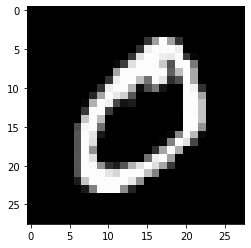

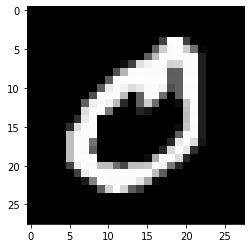

Similarity is True


In [9]:
# array index
pair_index = 0

show_image(tr_pairs[pair_index][0])
show_image(tr_pairs[pair_index][1])
print("Similarity is {}".format(tr_y[pair_index] == 1.0) )

In [9]:
def base_model():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [10]:
base_network = base_model()

In [11]:
# create the left input and point to the base network
input_a = Input(shape=(28,28,), name="left image")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28,28,), name="right image")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])


# specify the inputs and output of the model
model = Model([input_a, input_b], output)



In [22]:
model.compile(loss=contrastive_loss, optimizer=RMSprop())
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=30, batch_size=64, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/30
1694/1694 [==============================] - 8s 4ms/step - loss: 0.0120 - val_loss: 0.0318
Epoch 2/30
1694/1694 [==============================] - 7s 4ms/step - loss: 0.0123 - val_loss: 0.0321
Epoch 3/30
1694/1694 [==============================] - 9s 5ms/step - loss: 0.0125 - val_loss: 0.0316
Epoch 4/30
1694/1694 [==============================] - 8s 5ms/step - loss: 0.0124 - val_loss: 0.0322
Epoch 5/30
1694/1694 [==============================] - 9s 5ms/step - loss: 0.0136 - val_loss: 0.0309
Epoch 6/30
1694/1694 [==============================] - 7s 4ms/step - loss: 0.0130 - val_loss: 0.0319
Epoch 7/30
1694/1694 [==============================] - 7s 4ms/step - loss: 0.0124 - val_loss: 0.0324
Epoch 8/30
1694/1694 [==============================] - 8s 5ms/step - loss: 0.0128 - val_loss: 0.0318
Epoch 9/30
1694/1694 [==============================] - 7s 4ms/step - loss: 0.0133 - val_loss: 0.0318
Epoch 10/30
1694/1694 [==============================] - 7s 4ms/step - loss: 0.012

In [23]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)


557/557 [==============================] - 1s 2ms/step - loss: 0.0335


In [27]:
y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])

print(y_pred_train[0])

[0.00817061]


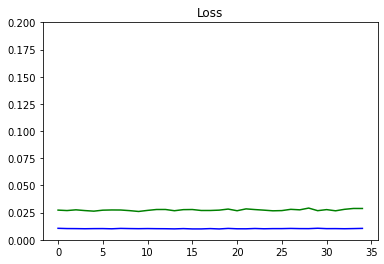

In [21]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [16]:
# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    
    plt.imshow(left, cmap="gray")
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right, cmap="gray")

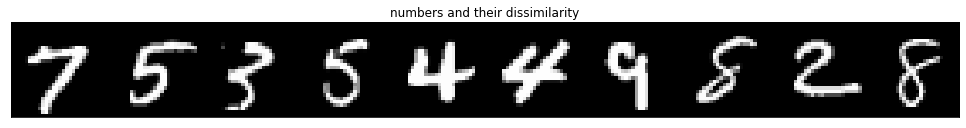

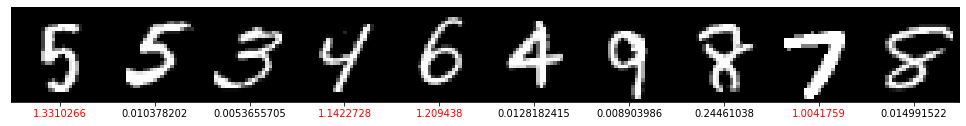

In [21]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "numbers and their dissimilarity", 10)

In [44]:
model.save('siames_network.h5')

In [14]:
model.load_weights('siames_network.h5')